# setup
https://github.com/lingchunkai/ACNet

In [1]:
!git clone https://github.com/lingchunkai/ACNet

Cloning into 'ACNet'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 60 (delta 24), reused 56 (delta 20), pack-reused 0
Receiving objects: 100% (60/60), 78.08 KiB | 2.79 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [2]:
%cd ACNet

/content/ACNet


In [3]:
!pip install sacred

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.9 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=62f0be1e0d19fe9599ce8f8f7c3e3d0ccde728911b8abe3aa901c3d86b867ca4
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [4]:
from main import Copula
from dirac_phi import DiracPhi
import pickle
#from sacred import Experiment
from train import load_data, load_log_ll
import torch
#from sacred.observers import FileStorageObserver#

In [5]:
from torch.autograd import Function, gradcheck
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
import os
from main import sample

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [7]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [9]:
from scipy.stats import bootstrap

# data
https://github.com/yutingng/gen-AC.git

In [10]:
import pandas as pd
import scipy
import copy

from sklearn.model_selection import train_test_split

In [11]:
def add_train_random_noise(data, num_adds):
  new_data = np.random.rand(num_adds, data.shape[1])
  return np.concatenate((data, new_data), axis = 0)

In [12]:
def rank_normalization(X):
  X = copy.deepcopy(X)
  for z in X:
      ndata = z.shape[0]
      gap = 1./(ndata+1)
      nfeats = z.shape[1]
      for i in range(nfeats):
          z[:, i] = scipy.stats.rankdata(z[:, i], 'ordinal')*gap
  return X

In [13]:
!git clone https://github.com/yutingng/gen-AC.git

Cloning into 'gen-AC'...
remote: Enumerating objects: 466, done.
remote: Counting objects: 100% (466/466), done.
remote: Compressing objects: 100% (339/339), done.
remote: Total 466 (delta 159), reused 421 (delta 123), pack-reused 0
Receiving objects: 100% (466/466), 10.28 MiB | 26.25 MiB/s, done.
Resolving deltas: 100% (159/159), done.


In [14]:
class Boston():
  def __init__(self):
    # read
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep = "\s+", skiprows = 22, header = None)
    X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    y = raw_df.values[1::2, 2]

    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 142857)
    X_train = np.concatenate((X_train, y_train[:, None]), axis = 1)
    X_test  = np.concatenate((X_test, y_test[:, None]), axis = 1)

    # norm
    [X_train, X_test] = rank_normalization([X_train, X_test])

    # noise
    X_train = add_train_random_noise(X_train, int(X_train.shape[0]*0.01))

    # 2d
    train_data = X_train[:, [0, 13]]
    test_data = X_test[:, [0, 13]]

    # flip
    train_data[:, 0] = 1 - train_data[:, 0]
    test_data[:, 0] = 1 - test_data[:, 0]

    self.train_y = train_data[:, 1].reshape(-1, 1)
    self.train_x = train_data[:, 0].reshape(-1, 1)
    self.validation_y = test_data[:, 1].reshape(-1, 1)
    self.validation_x = test_data[:, 0].reshape(-1, 1)

In [15]:
class INTC_MSFT():
  def __init__(self):
    # read
    intel_f = open('gen-AC/data/raw/INTC_MSFT_GE/INTEL.data', 'r')
    intel = np.array(list(map(float, intel_f.readlines())))

    ms_f = open('gen-AC/data/raw/INTC_MSFT_GE/MS.data', 'r')
    ms = np.array(list(map(float, ms_f.readlines())))

    ge_f = open('gen-AC/data/raw/INTC_MSFT_GE/GE.data', 'r')
    ge = np.array(list(map(float, ge_f.readlines())))

    # split
    X = np.concatenate((intel[:, None], ms[:, None]), axis = 1)
    X_train, X_test, _, _ = train_test_split(X, X, shuffle = True, random_state = 142857)

    # norm
    [X_train, X_test] = rank_normalization([X_train, X_test])

    # 2d, noise
    train_data = X_train[:, [0, 1]]
    train_data = add_train_random_noise(train_data, int(train_data.shape[0]*0.01))
    test_data = X_test[:, [0, 1]]

    self.train_y = train_data[:, 1].reshape(-1, 1)
    self.train_x = train_data[:, 0].reshape(-1, 1)
    self.validation_y = test_data[:, 1].reshape(-1, 1)
    self.validation_x = test_data[:, 0].reshape(-1, 1)

In [16]:
class GOOG_FB():
  def __init__(self):
    # read
    goog_f = open('gen-AC/data/raw/FB_GOOG/goog/close.vals', 'r')
    goog = np.array(list(map(float, goog_f.readlines())))

    fb_f = open('gen-AC/data/raw/FB_GOOG/fb/close.vals', 'r')
    fb = np.array(list(map(float, fb_f.readlines())))

    # split
    X = np.concatenate((goog[:, None], fb[:, None]), axis = 1)
    X_train, X_test, _, _ = train_test_split(X, X, shuffle=True, random_state=142857)

    # norm
    [X_train, X_test] = rank_normalization([X_train, X_test])

    # 2d, noise
    train_data = X_train[:, [0, 1]]
    train_data = add_train_random_noise(train_data, int(train_data.shape[0]*0.01))
    test_data = X_test[:, [0, 1]]

    self.train_y = train_data[:, 1].reshape(-1, 1)
    self.train_x = train_data[:, 0].reshape(-1, 1)
    self.validation_y = test_data[:, 1].reshape(-1, 1)
    self.validation_x = test_data[:, 0].reshape(-1, 1)

# params

In [8]:
def get_optim(name, net, args):
    if name == 'SGD':
        optimizer = optim.SGD(net.parameters(), args['lr'], args['momentum'])
    elif name == 'Adam':
        # TODO: add in more. Note: we do not use this in the paper.
        optimizer = optim.Adam(net.parameters(), args['lr'])
    elif name == 'RMSprop':
        # TODO: add in more. Note: we do not use this in the paper.
        optimizer = optim.RMSprop(net.parameters(), args['lr'])

    return optimizer


def expt(train_data, val_data,
         net,
         optim_name,
         optim_args,
         identifier,
         num_epochs=1000,
         batch_size=100,
         chkpt_freq=50,
         ):

    ''' if not os.path.exists('./checkpoints/%s'):
      os.mkdir('./checkpoints/%s' % identifier)
    if not os.path.exists('./sample_figs/%s'):
      os.mkdir('./sample_figs/%s' % identifier) '''

    train_loader = DataLoader(
        train_data, batch_size=batch_size, shuffle=True)

    # IMPORTANT: for this experiment, we did *not* perform hyperparameter tuning.
    # Hence, the `validation loss' here is essentially `test` loss.
    val_loader = DataLoader(
        val_data, batch_size=1000000, shuffle=True)

    optimizer = get_optim(optim_name, net, optim_args)

    train_loss_per_epoch = []

    for epoch in range(num_epochs):
        loss_per_minibatch = []
        for i, data in enumerate(train_loader, 0):
            optimizer.zero_grad()

            #d = data.clone().detach().requires_grad_(True)
            d = torch.tensor(data, requires_grad=True)
            p = net(d, mode='pdf')

            logloss = -torch.sum(torch.log(p))
            reg_loss = logloss
            reg_loss.backward()
            scalar_loss = (reg_loss/p.numel()).detach().numpy().item()

            loss_per_minibatch.append(scalar_loss)
            optimizer.step()

        train_loss_per_epoch.append(np.mean(loss_per_minibatch))
        print('Training loss at epoch %s: %s' %
              (epoch, train_loss_per_epoch[-1]))

        if epoch % chkpt_freq == 0:
            ''' print('Checkpointing')
            torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': logloss,
            }, './checkpoints/%s/epoch%s' % (identifier, epoch)) '''

            """
            if args.dims == 2:
                print('Scatter sampling')
                samples = sample(net, 2, 1000)
                plt.scatter(samples[:, 0], samples[:, 1])
                plt.savefig('./sample_figs/%s/epoch%s.png' %
                            (identifier, epoch))
                plt.clf()
            else:
                print('Not doign scatter plot, dims > 2')
            """

            print('Evaluating validation/test loss.')
            for j, val_data in enumerate(val_loader, 0):
                net.zero_grad()
                val_p = net(val_data, mode='pdf')
                val_loss = -torch.mean(torch.log(val_p))
            print('Average validation/test loss %s' % val_loss)

        if epoch == num_epochs - 1:
            print('Scatter sampling')
            samples = sample(net, 2, 1000)
            plt.scatter(samples[:, 0], samples[:, 1])
            plt.show()
    return val_p

In [17]:
optim_name = 'SGD'
optim_args = \
    {
        'lr': 1e-5,
        'momentum': 0.9
    }
num_epochs = 10000
batch_size = 200
chkpt_freq = 50

Phi = DiracPhi
phi_name = 'DiracPhi'

# Initial parameters.
depth = 2
widths = [10, 10]
lc_w_range = (0, 1.0)
shift_w_range = (0., 2.0)

identifier_id = 'None'

# boston

In [18]:
phi = Phi(depth, widths, lc_w_range, shift_w_range)
net = Copula(phi)

[tensor([1.0170, 0.0735, 1.4053, 0.0210, 1.0832, 1.2792, 0.6587, 1.1126, 0.8794,
        0.7918]), tensor([1.7505, 1.5669, 1.9602, 0.3015, 0.4478, 0.6246, 0.4828, 0.9162, 1.6811,
        0.0631])] [tensor([[0.1751, 0.9629, 0.2917, 0.8414, 0.5878, 0.6562, 0.7329, 0.8205, 0.3326,
         0.0062],
        [0.3594, 0.4089, 0.8696, 0.8311, 0.4073, 0.2483, 0.9550, 0.7780, 0.1170,
         0.7295],
        [0.2629, 0.6791, 0.0223, 0.8046, 0.9204, 0.4929, 0.5891, 0.6565, 0.9460,
         0.2178],
        [0.2419, 0.8191, 0.1954, 0.1165, 0.5725, 0.7135, 0.4255, 0.3233, 0.1419,
         0.8253],
        [0.4402, 0.4827, 0.9203, 0.0034, 0.4178, 0.4320, 0.5855, 0.8481, 0.5798,
         0.1670],
        [0.0270, 0.1427, 0.6273, 0.7075, 0.5045, 0.4018, 0.4511, 0.3007, 0.8393,
         0.6948],
        [0.7707, 0.2109, 0.7000, 0.9329, 0.6119, 0.0484, 0.2304, 0.3905, 0.7344,
         0.6969],
        [0.5940, 0.9094, 0.9212, 0.3520, 0.2625, 0.0370, 0.7771, 0.8115, 0.5927,
         0.2553],
        [0

In [19]:
data_loader = Boston()
train_D = np.array([data_loader.train_x, data_loader.train_y])[:, :, 0]
test_D = np.array([data_loader.validation_x, data_loader.validation_y])[:, :, 0]

In [20]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

<ipython-input-8-0cf8dd5cba73>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d = torch.tensor(data, requires_grad=True)


Streaming output truncated to the last 5000 lines.
Training loss at epoch 5194: -0.25976302303448606
Training loss at epoch 5195: -0.2602217083123916
Training loss at epoch 5196: -0.2596608759311542
Training loss at epoch 5197: -0.2561217239873595
Training loss at epoch 5198: -0.258790296528375
Training loss at epoch 5199: -0.25877395342608916
Training loss at epoch 5200: -0.2585792221159297
Evaluating validation/test loss.
Average validation/test loss tensor(-0.2735, grad_fn=<NegBackward0>)
Training loss at epoch 5201: -0.25903112331838646
Training loss at epoch 5202: -0.26081744253686445
Training loss at epoch 5203: -0.2574562345702315
Training loss at epoch 5204: -0.2597029692272108
Training loss at epoch 5205: -0.2612917634136733
Training loss at epoch 5206: -0.257728437533096
Training loss at epoch 5207: -0.260901077523373
Training loss at epoch 5208: -0.25652270952358563
Training loss at epoch 5209: -0.25931543570065196
Training loss at epoch 5210: -0.2592232784423858
Training lo

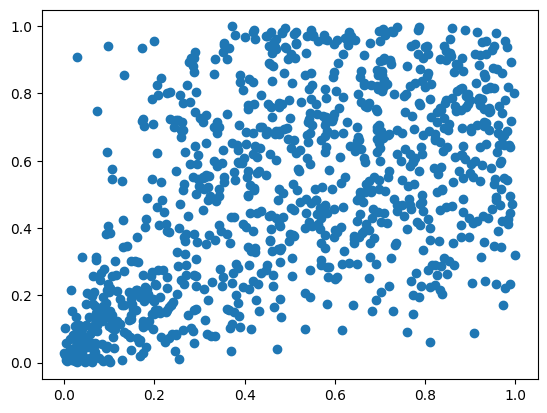

In [21]:
yhat = expt(train_data, test_data, net, optim_name, optim_args, identifier_id, num_epochs, batch_size, chkpt_freq)

In [22]:
yhat = -np.log(yhat.detach().numpy())

In [23]:
nll = np.mean(yhat)
nll

-0.2786811614767883

In [24]:
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.4f}$\pm${dev:.4f}')

NLL: -0.2787 RMean: -0.2778 IC: (-0.3869,-0.1715) Notation: -0.2778$\pm$0.1091


# intc-msft

In [25]:
phi = Phi(depth, widths, lc_w_range, shift_w_range)
net = Copula(phi)

[tensor([0.7941, 1.8414, 1.2065, 0.4112, 0.3592, 0.5021, 0.4783, 0.0620, 0.4338,
        0.4673]), tensor([0.3809, 0.7797, 0.0605, 1.6587, 1.6254, 0.6831, 1.3036, 1.2509, 0.0365,
        1.3908])] [tensor([[0.2800, 0.4503, 0.8032, 0.2133, 0.0108, 0.3652, 0.2190, 0.0231, 0.8298,
         0.2476],
        [0.2185, 0.7785, 0.4739, 0.1064, 0.7436, 0.5999, 0.4649, 0.0692, 0.8107,
         0.9410],
        [0.3196, 0.4665, 0.6627, 0.2996, 0.7915, 0.4809, 0.8486, 0.5343, 0.0485,
         0.1330],
        [0.0775, 0.5439, 0.1968, 0.6764, 0.4516, 0.1026, 0.9902, 0.1451, 0.2371,
         0.9160],
        [0.3770, 0.9467, 0.3848, 0.5607, 0.6520, 0.7302, 0.0641, 0.6112, 0.5701,
         0.1706],
        [0.4407, 0.2471, 0.6916, 0.2538, 0.0893, 0.2789, 0.5192, 0.5122, 0.5823,
         0.3978],
        [0.5449, 0.3296, 0.5972, 0.5440, 0.5301, 0.5476, 0.0229, 0.4030, 0.1360,
         0.0444],
        [0.2814, 0.0527, 0.7721, 0.7366, 0.9989, 0.8590, 0.5617, 0.0721, 0.5813,
         0.6805],
        [0

In [26]:
data_loader = INTC_MSFT()
train_D = np.array([data_loader.train_x, data_loader.train_y])[:, :, 0]
test_D = np.array([data_loader.validation_x, data_loader.validation_y])[:, :, 0]

In [27]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

<ipython-input-8-0cf8dd5cba73>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d = torch.tensor(data, requires_grad=True)


Streaming output truncated to the last 5000 lines.
Training loss at epoch 5194: -0.20915572545509348
Training loss at epoch 5195: -0.2169828667540242
Training loss at epoch 5196: -0.20894287794478905
Training loss at epoch 5197: -0.20894968635505035
Training loss at epoch 5198: -0.21228733695753385
Training loss at epoch 5199: -0.2129040620702943
Training loss at epoch 5200: -0.20858176964519917
Evaluating validation/test loss.
Average validation/test loss tensor(-0.1712, grad_fn=<NegBackward0>)
Training loss at epoch 5201: -0.21046210670286367
Training loss at epoch 5202: -0.20873382475195892
Training loss at epoch 5203: -0.21027313738176584
Training loss at epoch 5204: -0.20911766807713567
Training loss at epoch 5205: -0.21009696628139735
Training loss at epoch 5206: -0.21314397916329136
Training loss at epoch 5207: -0.20745107601023335
Training loss at epoch 5208: -0.21332662004841643
Training loss at epoch 5209: -0.20980894755819873
Training loss at epoch 5210: -0.21030320693114618

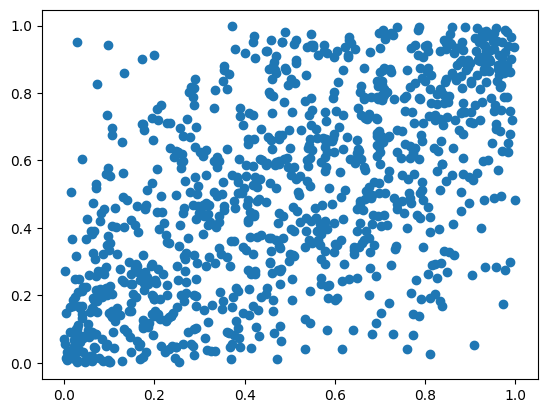

In [28]:
yhat = expt(train_data, test_data, net, optim_name, optim_args, identifier_id, num_epochs, batch_size, chkpt_freq)

In [29]:
yhat = -np.log(yhat.detach().numpy())

In [30]:
nll = np.mean(yhat)
nll

-0.17511419711886378

In [31]:
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.4f}$\pm${dev:.4f}')

NLL: -0.1751 RMean: -0.1757 IC: (-0.2448,-0.0985) Notation: -0.1757$\pm$0.0772


# goog-fb

In [32]:
phi = Phi(depth, widths, lc_w_range, shift_w_range)
net = Copula(phi)

[tensor([0.7464, 0.1780, 0.4103, 1.4569, 0.8672, 1.8189, 1.3961, 1.7460, 1.6206,
        0.9223]), tensor([0.0626, 0.1309, 0.3480, 1.0017, 1.6011, 1.2843, 0.5055, 0.8600, 0.7272,
        0.5205])] [tensor([[0.2532, 0.1979, 0.6159, 0.7471, 0.0908, 0.2655, 0.7688, 0.9149, 0.9907,
         0.8095],
        [0.7475, 0.2601, 0.4763, 0.2025, 0.0465, 0.8535, 0.8994, 0.5390, 0.3750,
         0.2550],
        [0.9181, 0.3367, 0.1669, 0.5435, 0.8700, 0.1289, 0.9845, 0.8205, 0.6521,
         0.5569],
        [0.6734, 0.9944, 0.4358, 0.9200, 0.7488, 0.6518, 0.1956, 0.2226, 0.7373,
         0.8119],
        [0.7496, 0.4880, 0.0990, 0.3795, 0.4445, 0.9728, 0.0752, 0.8925, 0.1325,
         0.2255],
        [0.0474, 0.8563, 0.1512, 0.2543, 0.7107, 0.5076, 0.4607, 0.8264, 0.5411,
         0.1397],
        [0.2921, 0.4462, 0.5782, 0.8731, 0.1450, 0.9208, 0.1658, 0.9720, 0.0873,
         0.3125],
        [0.2267, 0.7551, 0.8755, 0.8021, 0.3873, 0.9142, 0.1393, 0.3562, 0.4914,
         0.8616],
        [0

In [33]:
data_loader = GOOG_FB()
train_D = np.array([data_loader.train_x, data_loader.train_y])[:, :, 0]
test_D = np.array([data_loader.validation_x, data_loader.validation_y])[:, :, 0]

In [34]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

<ipython-input-8-0cf8dd5cba73>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d = torch.tensor(data, requires_grad=True)


Streaming output truncated to the last 5000 lines.
Training loss at epoch 5194: -1.060317494133662
Training loss at epoch 5195: -1.0621271220278456
Training loss at epoch 5196: -1.0565524792098864
Training loss at epoch 5197: -1.059236269441247
Training loss at epoch 5198: -1.0606811667142177
Training loss at epoch 5199: -1.0630259255208856
Training loss at epoch 5200: -1.059668093006187
Evaluating validation/test loss.
Average validation/test loss tensor(-0.9201, grad_fn=<NegBackward0>)
Training loss at epoch 5201: -1.058377498877895
Training loss at epoch 5202: -1.0607102693521875
Training loss at epoch 5203: -1.0574181060240477
Training loss at epoch 5204: -1.0649907235376652
Training loss at epoch 5205: -1.0601167676385765
Training loss at epoch 5206: -1.063053706677143
Training loss at epoch 5207: -1.0555173710491175
Training loss at epoch 5208: -1.0601629595660946
Training loss at epoch 5209: -1.0622684013989188
Training loss at epoch 5210: -1.0604507936226601
Training loss at ep

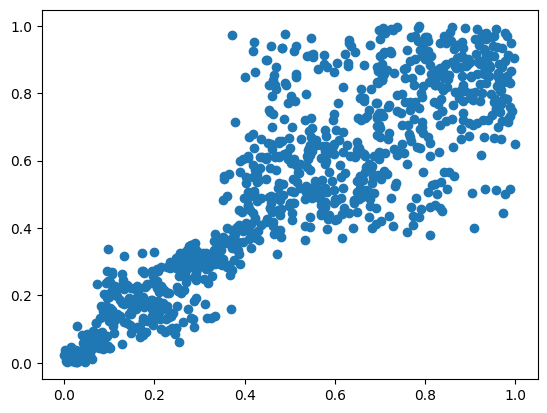

In [35]:
yhat = expt(train_data, test_data, net, optim_name, optim_args, identifier_id, num_epochs, batch_size, chkpt_freq)

In [36]:
yhat = -np.log(yhat.detach().numpy())

In [37]:
nll = np.mean(yhat)
nll

-0.9147279404976375

In [38]:
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.4f}$\pm${dev:.4f}')

NLL: -0.9147 RMean: -0.9149 IC: (-1.0291,-0.7912) Notation: -0.9149$\pm$0.1237
